In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import functions as fc
# from functions import display, display_tuning, evaluation_model, evaluation_model_unbias, hyperparameter_tuning_random, hyperparameter_tuning_grid

df_5output = pd.read_excel('data-5features-all-outputs.xlsx')
df_30output = pd.read_excel('data-30-features-all-outputs.xlsx')
df_all = pd.read_excel('All_data_correct.xlsx')
df_all.drop(columns=["Responsibility", "Listening_skills", "Questioning_skills", "Team_participation", "Teamwork_oriented"], inplace=True)

personality_names = list(df_30output.iloc[:, :30])
bigfive_names = list(df_5output.iloc[:, 2:7])
target = 'Team_Climate'
other_outputs = list(df_5output.iloc[:, 7:-1])
X_5_features = df_all[bigfive_names]
X_30_features = df_all[personality_names]
y = df_all[target]

Setting up input and output variables names

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score

numerical_features = df_all.iloc[:, 9:]
numerical_features_names = list(df_all.iloc[:, 9:])

# Normalisation of the data
df_all[numerical_features_names] = (numerical_features - numerical_features.min())/(numerical_features.max()-numerical_features.min())

In [6]:
def display(test, train, mse, r2):
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f"Test score: {test}")
    print(f"Train score: {train}")

def display_tuning(test,train,val,param,score):
    print(f"Best params: {param}")
    print(f"Best scores: {score}")
    print(f"Test score: {test}")
    print(f"Train score: {train}")
    print(f"Validation score: {val}")

# Setup 1: Without preventing bias of TeamID

Evaluation of the models without hyperparameter tuning

In [7]:
def evaluation_model(X, y, clf, n_runs=30, test_size=0.2):
    test_score = []
    train_score = []
    mse = []
    r2 = []
    for i in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = clf.score(X_test, y_test)
        score2 = clf.score(X_train, y_train)
        test_score.append(score)
        train_score.append(score2)
        mse.append(mean_squared_error(y_test, y_pred))
        r2.append(r2_score(y_test, y_pred))

    display(np.mean(test_score), np.mean(train_score), np.mean(mse), np.mean(r2))
    return np.mean(test_score), np.mean(train_score), np.mean(mse), np.mean(r2)

In [8]:
rft_results = {}
gbr_results = {}
rft = RandomForestRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

In [9]:
rft_results['5_features_team_climate'] = evaluation_model(df_all[bigfive_names], y, rft)
rft_results['30_features_team_climate'] = evaluation_model(df_all[personality_names], y, rft)
gbr_results['5_features_team_climate'] = evaluation_model(df_all[bigfive_names], y, gbr)
gbr_results['30_features_team_climate'] = evaluation_model(df_all[personality_names], y, gbr)

Mean Squared Error: 0.35786369033880944
R^2 Score: -0.0220841429596625
Test score: -0.0220841429596625
Train score: 0.8548515236771462
Mean Squared Error: 0.35230521550872934
R^2 Score: -0.0015974391773080688
Test score: -0.0015974391773080688
Train score: 0.8581032578299275
Mean Squared Error: 0.4058781723703214
R^2 Score: -0.16251024323832908
Test score: -0.16251024323832908
Train score: 0.7603296912627732
Mean Squared Error: 0.4098272256105693
R^2 Score: -0.17383789330666186
Test score: -0.17383789330666186
Train score: 0.9174497788324941


In [27]:
rft_results

{}

In [28]:
gbr_results

{}

Evaluation of the Random Forest with hyperparameter tuning

In [29]:
rft_tuned = RandomForestRegressor(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42)
test, train, mse, r2 = fc.evaluation_model(df_all[bigfive_names], df_all[target], rft_tuned)
# fc.display(test,train,mse,r2)
test, train, mse, r2 = fc.evaluation_model(df_all[personality_names], df_all[target], rft_tuned)
# fc.display(test,train,mse,r2)

AttributeError: module 'functions' has no attribute 'evaluation_model'

# Setup 2: Preventing bias of Team ID

There is an overfitting because the model performs well on the training data, obtaining a low error and performs poorly on the test data. (Low bias, high variance)
A main cause might be the insufficient amount of training data to represent the underlying distribution properly.

In [ ]:
def evaluation_model_unbias(df, input_features, output_feature, team_ids, clf, n_runs=30, test_size=0.2):
    test_score = []
    train_score = []
    mse = []
    r2 = []
    for i in range(n_runs):
        train_teams, test_teams = train_test_split(team_ids, test_size=test_size, random_state=i)
        train_df = df[df['Team ID'].isin(train_teams)]
        test_df = df[df['Team ID'].isin(test_teams)]

        X_train = train_df[input_features]
        X_test = test_df[input_features]
        y_train = train_df[output_feature]
        y_test = test_df[output_feature]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = clf.score(X_test, y_test)
        score2 = clf.score(X_train, y_train)
        test_score.append(score)
        train_score.append(score2)
        mse.append(mean_squared_error(y_test, y_pred))
        r2.append(r2_score(y_test, y_pred))

    display(np.mean(test_score), np.mean(train_score), np.mean(mse), np.mean(r2))
    return np.mean(test_score), np.mean(train_score), np.mean(mse), np.mean(r2)

In [30]:
team_ids = df_all['Team ID'].unique()
rft = RandomForestRegressor(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42)
# The team ids are splitted into training and testing
test, train, mse, r2 = fc.evaluation_model_unbias(df_all, personality_names, target, team_ids, rft, True)
fc.display(test, train, mse, r2)
test, train, mse, r2 = fc.evaluation_model_unbias(df_all, bigfive_names, target, team_ids, rft, True)
fc.display(test, train, mse, r2)

AttributeError: module 'functions' has no attribute 'evaluation_model_unbias'

In [31]:
gbc = GradientBoostingRegressor(n_estimators=100, learning_rate=1, max_depth=1, random_state=42)


# Setup 3: Splitting data into training, validation and test

As a summary, a training dataset trains the different algorithms we have available, and a validation dataset compares performance of the different algorithms (with different hyperparameters) and decides which one to take. A testing dataset gives the accuracy, sensitivity, and performance of the specific model.

In [32]:
param_grid_rft = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_dec = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15]
}

In [33]:
rft = RandomForestRegressor(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_all[personality_names], df_all[target], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
test, train, val, param, score = fc.hyperparameter_tuning_grid(X_train, X_test, X_val, y_train, y_test, y_val, param_grid_rft, rft)
# fc.display(test,train,val,param,score)

AttributeError: module 'functions' has no attribute 'hyperparameter_tuning_grid'

combine training and validation

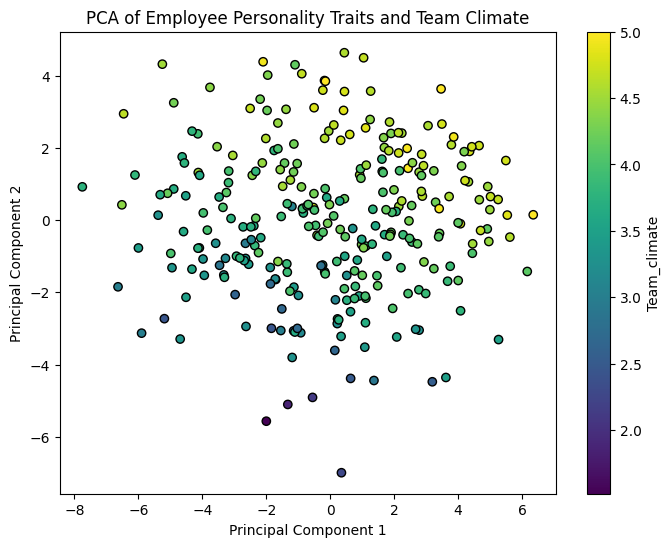

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_pca = df_all.iloc[:, 9:]
target = df_pca['Team_Climate']
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(df_pca))

pca = PCA(n_components=5)
pca_result = pca.fit_transform(scaled_data)
# pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df = pd.DataFrame(pca_result)
pca_df['Team_Climate'] = target.values

plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df[0], pca_df[1], c=pca_df['Team_Climate'], cmap='viridis', edgecolor='k')
plt.colorbar(scatter, label='Team_climate')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Employee Personality Traits and Team Climate')
plt.savefig('PCA.png')

plt.show()

try to train clf with the transformed data (try more pcas)

In [35]:
from sklearn.metrics import accuracy_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_result, target, test_size=0.2, random_state=42)

# Training a Logistic Regression model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = model.score(y_test, y_pred)
print("Accuracy:", accuracy)


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

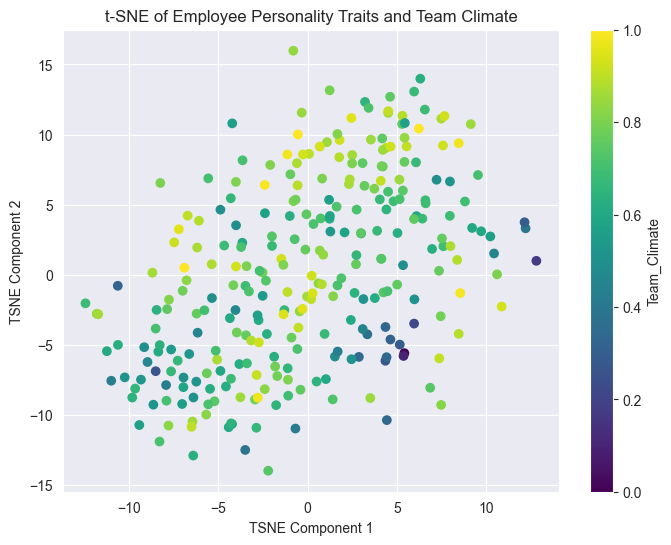

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2 ,perplexity=30, max_iter=300, learning_rate=100, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['Team_Climate'] = target.values

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['Team_Climate'], cmap='viridis')
plt.colorbar(scatter, label='Team_Climate')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE of Employee Personality Traits and Team Climate')
plt.savefig('TSNE.png')
plt.show()